In [1]:
!pip install torchinfo torchmetrics transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [2]:
import os
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchmetrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch import nn, optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torchinfo import summary
from tqdm import tqdm
from transformers import BertConfig, BertForSequenceClassification, BertTokenizer

warnings.filterwarnings('ignore')

In [3]:
torch.__version__

'2.2.1+cu121'

In [4]:
!nvidia-smi

Mon Apr  8 15:24:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               8W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


def count_param(module: nn.Module, trainable=False) -> int:
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())


def get_lr(optimizer: optim.Optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


def freeze_layers(layers: nn.Module) -> None:
    for layer in layers.parameters():
        layer.requires_grad = False


def metrics_to_string(metric_dict: dict) -> str:
    string_list = []
    for key, value in metric_dict.items():
        string_list.append("{}:{:.2f}".format(key, value))
    return " ".join(string_list)

In [6]:
set_seed(2024)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [8]:
class DocumentSentimentDataset(Dataset):
    # Static constant variable
    LABEL2INDEX = {"positive": 0, "neutral": 1, "negative": 2}
    INDEX2LABEL = {0: "positive", 1: "neutral", 2: "negative"}
    NUM_LABELS = 3

    def load_dataset(self, path):
        df = pd.read_csv(path)
        df.columns = ["text", "sentiment"]
        df["sentiment"] = df["sentiment"].apply(lambda lab: self.LABEL2INDEX[lab])
        return df

    def __init__(
        self,
        dataset_path: str,
        tokenizer: BertTokenizer,
        no_special_token=False,
        *args,
        **kwargs,
    ):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token

    def __getitem__(self, index):
        data = self.data.loc[index, :]
        text, sentiment = data["text"], data["sentiment"]
        subwords = self.tokenizer.encode(
            text, add_special_tokens=not self.no_special_token
        )
        return np.array(subwords), np.array(sentiment), data["text"]

    def __len__(self):
        return len(self.data)

In [9]:
class DocumentSentimentDataLoader(DataLoader):
    def __init__(self, max_seq_len=512, *args, **kwargs):
        super(DocumentSentimentDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len

    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)

        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        sentiment_batch = np.zeros((batch_size, 1), dtype=np.int64)

        seq_list = []
        for i, (subwords, sentiment, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i, : len(subwords)] = subwords
            mask_batch[i, : len(subwords)] = 1
            sentiment_batch[i, 0] = sentiment

            seq_list.append(raw_seq)

        return subword_batch, mask_batch, sentiment_batch, seq_list

In [10]:
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
config = BertConfig.from_pretrained("indobenchmark/indobert-base-p1")
config.num_labels = 3


model = BertForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1", config=config
).to(device)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# freeze_layers(model.bert.embeddings)
# freeze_layers(model.bert.encoder.layer[:-3])
# freeze_layers(model.bert.encoder)

In [12]:
summary(
    model=model,
    input_size=(1, 7),
    dtypes=[torch.long],
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=16,
    row_settings=["var_names"],
)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Layer (type (var_name))                                                Input Shape      Output Shape     Param #          Trainable
BertForSequenceClassification (BertForSequenceClassification)          [1, 7]           [1, 3]           --               True
├─BertModel (bert)                                                     [1, 7]           [1, 768]         --               True
│    └─BertEmbeddings (embeddings)                                     --               [1, 7, 768]      --               True
│    │    └─Embedding (word_embeddings)                                [1, 7]           [1, 7, 768]      38,400,000       True
│    │    └─Embedding (token_type_embeddings)                          [1, 7]           [1, 7, 768]      1,536            True
│    │    └─Embedding (position_embeddings)                            [1, 7]           [1, 7, 768]      393,216          True
│    │    └─LayerNorm (LayerNorm)                                      [1, 7, 768]      [1, 7, 768]      1

In [13]:
train_path = "tws-train.csv"
test_path = "tws-test.csv"

In [14]:
train_dataset = DocumentSentimentDataset(train_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_path, tokenizer, lowercase=True)

In [15]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DocumentSentimentDataLoader(
    dataset=train_dataset,
    max_seq_len=512,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

test_dataloader = DocumentSentimentDataLoader(
    dataset=test_dataset,
    max_seq_len=512,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

In [16]:
NUM_WORKERS

2

In [17]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
w2i, i2w

({'positive': 0, 'neutral': 1, 'negative': 2},
 {0: 'positive', 1: 'neutral', 2: 'negative'})

In [18]:
# Forward function for sequence classification
def forward_sequence_classification(
    model: BertForSequenceClassification,
    batch_data,
    i2w,
    is_test=False,
    device=device,
    **kwargs,
):
    # Unpack batch data
    if len(batch_data) == 3:
        (subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 4:
        (subword_batch, mask_batch, token_type_batch, label_batch) = batch_data

    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch)
    mask_batch = torch.FloatTensor(mask_batch)
    token_type_batch = (
        torch.LongTensor(token_type_batch) if token_type_batch is not None else None
    )
    label_batch = torch.LongTensor(label_batch)

    if device == "cuda":
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = (
            token_type_batch.cuda() if token_type_batch is not None else None
        )
        label_batch = label_batch.cuda()

    # Forward model
    outputs = model(
        subword_batch,
        attention_mask=mask_batch,
        token_type_ids=token_type_batch,
        labels=label_batch,
    )
    loss, logits = outputs[:2]

    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = torch.topk(logits, 1)[1]
    for j in range(len(hyp)):
        list_hyp.append(i2w[hyp[j].item()])
        list_label.append(i2w[label_batch[j][0].item()])

    return loss, list_hyp, list_label

In [19]:
def document_sentiment_metrics_fn(list_hyp, list_label):
    metrics = {}
    metrics["ACC"] = accuracy_score(list_label, list_hyp)
    metrics["F1"] = f1_score(list_label, list_hyp, average="macro")
    metrics["REC"] = recall_score(list_label, list_hyp, average="macro")
    metrics["PRE"] = precision_score(list_label, list_hyp, average="macro")
    return metrics

In [20]:
optimizer = optim.Adam(
    model.parameters(),
    lr=3e-6,
    weight_decay=0.3,
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.0001, threshold_mode='abs')

In [21]:
epochs = 100

train_loss_values = []
test_loss_values = []
train_metrics_values = []
test_metrics_values = []

for epoch in range(epochs):
    model.train()

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_dataloader, leave=True, total=len(train_dataloader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(
            model, batch_data[:-1], i2w=i2w, device="cuda"
        )

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss = total_train_loss + loss.item()

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description(f"(Epoch {epoch+1}) TRAIN LOSS:{total_train_loss / (i+1):.4f} LR:{get_lr(optimizer):.6f}")

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print(f"(Epoch {epoch+1}) TRAIN LOSS:{total_train_loss / (i+1):.4f} {metrics_to_string(metrics)} LR:{get_lr(optimizer):.6f}")
    train_loss_values.append(total_train_loss)
    train_metrics_values.append(metrics['ACC'])

    # Evaluate on validation
    model.eval()

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    test_pbar = tqdm(test_dataloader, leave=True, total=len(test_dataloader))
    with torch.inference_mode():
        for i, batch_data in enumerate(test_pbar):
            batch_seq = batch_data[-1]
            loss, batch_hyp, batch_label = forward_sequence_classification(
                model, batch_data[:-1], i2w=i2w, device="cuda"
            )

            # Calculate total loss
            valid_loss = loss.item()
            total_loss = total_loss + valid_loss

            # Calculate evaluation metrics
            list_hyp += batch_hyp
            list_label += batch_label
            test_pbar.set_description(f"VALID LOSS:{total_loss / (i+1):.4f} {metrics_to_string(metrics)}")

    # Update model
    scheduler.step(total_loss)

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print(f"(Epoch {epoch+1}) VALID LOSS:{total_loss / (i+1):.4f} {metrics_to_string(metrics)}")
    test_loss_values.append(total_loss)
    test_metrics_values.append(metrics['ACC'])

(Epoch 1) TRAIN LOSS:1.0865 LR:0.000003: 100%|██████████| 150/150 [00:27<00:00,  5.42it/s]


(Epoch 1) TRAIN LOSS:1.0865 ACC:0.39 F1:0.35 REC:0.39 PRE:0.49 LR:0.000003


VALID LOSS:1.0175 ACC:0.39 F1:0.35 REC:0.39 PRE:0.49: 100%|██████████| 38/38 [00:02<00:00, 17.15it/s]


(Epoch 1) VALID LOSS:1.0175 ACC:0.50 F1:0.49 REC:0.50 PRE:0.54


(Epoch 2) TRAIN LOSS:0.9533 LR:0.000003: 100%|██████████| 150/150 [00:23<00:00,  6.42it/s]


(Epoch 2) TRAIN LOSS:0.9533 ACC:0.56 F1:0.56 REC:0.56 PRE:0.58 LR:0.000003


VALID LOSS:0.8809 ACC:0.56 F1:0.56 REC:0.56 PRE:0.58: 100%|██████████| 38/38 [00:01<00:00, 22.01it/s]


(Epoch 2) VALID LOSS:0.8809 ACC:0.65 F1:0.65 REC:0.65 PRE:0.67


(Epoch 3) TRAIN LOSS:0.8306 LR:0.000003: 100%|██████████| 150/150 [00:23<00:00,  6.43it/s]


(Epoch 3) TRAIN LOSS:0.8306 ACC:0.64 F1:0.64 REC:0.64 PRE:0.64 LR:0.000003


VALID LOSS:0.7848 ACC:0.64 F1:0.64 REC:0.64 PRE:0.64: 100%|██████████| 38/38 [00:01<00:00, 21.66it/s]


(Epoch 3) VALID LOSS:0.7848 ACC:0.68 F1:0.68 REC:0.68 PRE:0.68


(Epoch 4) TRAIN LOSS:0.7529 LR:0.000003: 100%|██████████| 150/150 [00:23<00:00,  6.37it/s]


(Epoch 4) TRAIN LOSS:0.7529 ACC:0.69 F1:0.69 REC:0.69 PRE:0.69 LR:0.000003


VALID LOSS:0.7323 ACC:0.69 F1:0.69 REC:0.69 PRE:0.69: 100%|██████████| 38/38 [00:01<00:00, 21.43it/s]


(Epoch 4) VALID LOSS:0.7323 ACC:0.72 F1:0.72 REC:0.72 PRE:0.72


(Epoch 5) TRAIN LOSS:0.7066 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.15it/s]


(Epoch 5) TRAIN LOSS:0.7066 ACC:0.72 F1:0.72 REC:0.72 PRE:0.72 LR:0.000003


VALID LOSS:0.6966 ACC:0.72 F1:0.72 REC:0.72 PRE:0.72: 100%|██████████| 38/38 [00:01<00:00, 21.18it/s]


(Epoch 5) VALID LOSS:0.6966 ACC:0.73 F1:0.73 REC:0.73 PRE:0.73


(Epoch 6) TRAIN LOSS:0.6702 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.01it/s]


(Epoch 6) TRAIN LOSS:0.6702 ACC:0.74 F1:0.74 REC:0.74 PRE:0.74 LR:0.000003


VALID LOSS:0.6625 ACC:0.74 F1:0.74 REC:0.74 PRE:0.74: 100%|██████████| 38/38 [00:02<00:00, 18.17it/s]


(Epoch 6) VALID LOSS:0.6625 ACC:0.73 F1:0.73 REC:0.73 PRE:0.73


(Epoch 7) TRAIN LOSS:0.6336 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.12it/s]


(Epoch 7) TRAIN LOSS:0.6336 ACC:0.76 F1:0.76 REC:0.76 PRE:0.76 LR:0.000003


VALID LOSS:0.6348 ACC:0.76 F1:0.76 REC:0.76 PRE:0.76: 100%|██████████| 38/38 [00:01<00:00, 20.69it/s]


(Epoch 7) VALID LOSS:0.6348 ACC:0.75 F1:0.75 REC:0.75 PRE:0.76


(Epoch 8) TRAIN LOSS:0.6082 LR:0.000003: 100%|██████████| 150/150 [00:25<00:00,  5.79it/s]


(Epoch 8) TRAIN LOSS:0.6082 ACC:0.77 F1:0.77 REC:0.77 PRE:0.77 LR:0.000003


VALID LOSS:0.6132 ACC:0.77 F1:0.77 REC:0.77 PRE:0.77: 100%|██████████| 38/38 [00:02<00:00, 16.22it/s]


(Epoch 8) VALID LOSS:0.6132 ACC:0.77 F1:0.77 REC:0.77 PRE:0.78


(Epoch 9) TRAIN LOSS:0.5777 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.05it/s]


(Epoch 9) TRAIN LOSS:0.5777 ACC:0.79 F1:0.79 REC:0.79 PRE:0.79 LR:0.000003


VALID LOSS:0.5827 ACC:0.79 F1:0.79 REC:0.79 PRE:0.79: 100%|██████████| 38/38 [00:01<00:00, 21.10it/s]


(Epoch 9) VALID LOSS:0.5827 ACC:0.79 F1:0.79 REC:0.79 PRE:0.79


(Epoch 10) TRAIN LOSS:0.5527 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.17it/s]


(Epoch 10) TRAIN LOSS:0.5527 ACC:0.80 F1:0.80 REC:0.80 PRE:0.80 LR:0.000003


VALID LOSS:0.5590 ACC:0.80 F1:0.80 REC:0.80 PRE:0.80: 100%|██████████| 38/38 [00:01<00:00, 21.25it/s]


(Epoch 10) VALID LOSS:0.5590 ACC:0.80 F1:0.80 REC:0.80 PRE:0.81


(Epoch 11) TRAIN LOSS:0.5287 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.15it/s]


(Epoch 11) TRAIN LOSS:0.5287 ACC:0.81 F1:0.81 REC:0.81 PRE:0.81 LR:0.000003


VALID LOSS:0.5323 ACC:0.81 F1:0.81 REC:0.81 PRE:0.81: 100%|██████████| 38/38 [00:02<00:00, 18.44it/s]


(Epoch 11) VALID LOSS:0.5323 ACC:0.82 F1:0.83 REC:0.82 PRE:0.83


(Epoch 12) TRAIN LOSS:0.5018 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.14it/s]


(Epoch 12) TRAIN LOSS:0.5018 ACC:0.83 F1:0.83 REC:0.83 PRE:0.83 LR:0.000003


VALID LOSS:0.5082 ACC:0.83 F1:0.83 REC:0.83 PRE:0.83: 100%|██████████| 38/38 [00:01<00:00, 19.84it/s]


(Epoch 12) VALID LOSS:0.5082 ACC:0.83 F1:0.83 REC:0.83 PRE:0.83


(Epoch 13) TRAIN LOSS:0.4801 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.16it/s]


(Epoch 13) TRAIN LOSS:0.4801 ACC:0.84 F1:0.84 REC:0.84 PRE:0.84 LR:0.000003


VALID LOSS:0.4910 ACC:0.84 F1:0.84 REC:0.84 PRE:0.84: 100%|██████████| 38/38 [00:01<00:00, 20.76it/s]


(Epoch 13) VALID LOSS:0.4910 ACC:0.83 F1:0.83 REC:0.83 PRE:0.85


(Epoch 14) TRAIN LOSS:0.4621 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.16it/s]


(Epoch 14) TRAIN LOSS:0.4621 ACC:0.85 F1:0.85 REC:0.85 PRE:0.85 LR:0.000003


VALID LOSS:0.4618 ACC:0.85 F1:0.85 REC:0.85 PRE:0.85: 100%|██████████| 38/38 [00:01<00:00, 20.89it/s]


(Epoch 14) VALID LOSS:0.4618 ACC:0.85 F1:0.85 REC:0.85 PRE:0.86


(Epoch 15) TRAIN LOSS:0.4362 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.14it/s]


(Epoch 15) TRAIN LOSS:0.4362 ACC:0.87 F1:0.87 REC:0.87 PRE:0.87 LR:0.000003


VALID LOSS:0.4437 ACC:0.87 F1:0.87 REC:0.87 PRE:0.87: 100%|██████████| 38/38 [00:01<00:00, 20.97it/s]


(Epoch 15) VALID LOSS:0.4437 ACC:0.86 F1:0.86 REC:0.86 PRE:0.87


(Epoch 16) TRAIN LOSS:0.4153 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.17it/s]


(Epoch 16) TRAIN LOSS:0.4153 ACC:0.88 F1:0.88 REC:0.88 PRE:0.88 LR:0.000003


VALID LOSS:0.4183 ACC:0.88 F1:0.88 REC:0.88 PRE:0.88: 100%|██████████| 38/38 [00:01<00:00, 21.14it/s]


(Epoch 16) VALID LOSS:0.4183 ACC:0.87 F1:0.87 REC:0.87 PRE:0.88


(Epoch 17) TRAIN LOSS:0.4011 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.20it/s]


(Epoch 17) TRAIN LOSS:0.4011 ACC:0.88 F1:0.88 REC:0.88 PRE:0.88 LR:0.000003


VALID LOSS:0.4022 ACC:0.88 F1:0.88 REC:0.88 PRE:0.88: 100%|██████████| 38/38 [00:01<00:00, 20.11it/s]


(Epoch 17) VALID LOSS:0.4022 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89


(Epoch 18) TRAIN LOSS:0.3856 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.16it/s]


(Epoch 18) TRAIN LOSS:0.3856 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89 LR:0.000003


VALID LOSS:0.3941 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89: 100%|██████████| 38/38 [00:02<00:00, 18.28it/s]


(Epoch 18) VALID LOSS:0.3941 ACC:0.88 F1:0.88 REC:0.88 PRE:0.88


(Epoch 19) TRAIN LOSS:0.3702 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.09it/s]


(Epoch 19) TRAIN LOSS:0.3702 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89 LR:0.000003


VALID LOSS:0.3726 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89: 100%|██████████| 38/38 [00:01<00:00, 20.79it/s]


(Epoch 19) VALID LOSS:0.3726 ACC:0.89 F1:0.89 REC:0.89 PRE:0.90


(Epoch 20) TRAIN LOSS:0.3602 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.14it/s]


(Epoch 20) TRAIN LOSS:0.3602 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90 LR:0.000003


VALID LOSS:0.3616 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90: 100%|██████████| 38/38 [00:01<00:00, 21.13it/s]


(Epoch 20) VALID LOSS:0.3616 ACC:0.89 F1:0.89 REC:0.89 PRE:0.90


(Epoch 21) TRAIN LOSS:0.3510 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.16it/s]


(Epoch 21) TRAIN LOSS:0.3510 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90 LR:0.000003


VALID LOSS:0.3474 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90: 100%|██████████| 38/38 [00:01<00:00, 20.90it/s]


(Epoch 21) VALID LOSS:0.3474 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 22) TRAIN LOSS:0.3426 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.14it/s]


(Epoch 22) TRAIN LOSS:0.3426 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3527 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.96it/s]


(Epoch 22) VALID LOSS:0.3527 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 23) TRAIN LOSS:0.3328 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.17it/s]


(Epoch 23) TRAIN LOSS:0.3328 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90 LR:0.000003


VALID LOSS:0.3309 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90: 100%|██████████| 38/38 [00:01<00:00, 20.95it/s]


(Epoch 23) VALID LOSS:0.3309 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91


(Epoch 24) TRAIN LOSS:0.3339 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.20it/s]


(Epoch 24) TRAIN LOSS:0.3339 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90 LR:0.000003


VALID LOSS:0.3337 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90: 100%|██████████| 38/38 [00:01<00:00, 19.13it/s]


(Epoch 24) VALID LOSS:0.3337 ACC:0.90 F1:0.90 REC:0.90 PRE:0.91


(Epoch 25) TRAIN LOSS:0.3246 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.10it/s]


(Epoch 25) TRAIN LOSS:0.3246 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3177 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 19.80it/s]


(Epoch 25) VALID LOSS:0.3177 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91


(Epoch 26) TRAIN LOSS:0.3215 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.13it/s]


(Epoch 26) TRAIN LOSS:0.3215 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3155 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.88it/s]


(Epoch 26) VALID LOSS:0.3155 ACC:0.90 F1:0.90 REC:0.90 PRE:0.91


(Epoch 27) TRAIN LOSS:0.3185 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.11it/s]


(Epoch 27) TRAIN LOSS:0.3185 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3349 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.97it/s]


(Epoch 27) VALID LOSS:0.3349 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 28) TRAIN LOSS:0.3147 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.15it/s]


(Epoch 28) TRAIN LOSS:0.3147 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3168 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.98it/s]


(Epoch 28) VALID LOSS:0.3168 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91


(Epoch 29) TRAIN LOSS:0.3167 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.17it/s]


(Epoch 29) TRAIN LOSS:0.3167 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3074 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.69it/s]


(Epoch 29) VALID LOSS:0.3074 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91


(Epoch 30) TRAIN LOSS:0.3104 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.13it/s]


(Epoch 30) TRAIN LOSS:0.3104 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3231 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:02<00:00, 18.96it/s]


(Epoch 30) VALID LOSS:0.3231 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 31) TRAIN LOSS:0.3158 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.09it/s]


(Epoch 31) TRAIN LOSS:0.3158 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3038 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 19.40it/s]


(Epoch 31) VALID LOSS:0.3038 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91


(Epoch 32) TRAIN LOSS:0.3155 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.11it/s]


(Epoch 32) TRAIN LOSS:0.3155 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3068 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.87it/s]


(Epoch 32) VALID LOSS:0.3068 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91


(Epoch 33) TRAIN LOSS:0.3170 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.12it/s]


(Epoch 33) TRAIN LOSS:0.3170 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3040 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.84it/s]


(Epoch 33) VALID LOSS:0.3040 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91


(Epoch 34) TRAIN LOSS:0.3134 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.13it/s]


(Epoch 34) TRAIN LOSS:0.3134 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3093 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.93it/s]


(Epoch 34) VALID LOSS:0.3093 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 35) TRAIN LOSS:0.3162 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.24it/s]


(Epoch 35) TRAIN LOSS:0.3162 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3113 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.93it/s]


(Epoch 35) VALID LOSS:0.3113 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 36) TRAIN LOSS:0.3171 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.14it/s]


(Epoch 36) TRAIN LOSS:0.3171 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3370 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.12it/s]


(Epoch 36) VALID LOSS:0.3370 ACC:0.89 F1:0.89 REC:0.89 PRE:0.90


(Epoch 37) TRAIN LOSS:0.3187 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.12it/s]


(Epoch 37) TRAIN LOSS:0.3187 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3132 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:02<00:00, 18.93it/s]


(Epoch 37) VALID LOSS:0.3132 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 38) TRAIN LOSS:0.3178 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.13it/s]


(Epoch 38) TRAIN LOSS:0.3178 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3027 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.92it/s]


(Epoch 38) VALID LOSS:0.3027 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91


(Epoch 39) TRAIN LOSS:0.3153 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.14it/s]


(Epoch 39) TRAIN LOSS:0.3153 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3147 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.86it/s]


(Epoch 39) VALID LOSS:0.3147 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 40) TRAIN LOSS:0.3171 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.16it/s]


(Epoch 40) TRAIN LOSS:0.3171 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3150 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.74it/s]


(Epoch 40) VALID LOSS:0.3150 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 41) TRAIN LOSS:0.3178 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.11it/s]


(Epoch 41) TRAIN LOSS:0.3178 ACC:0.90 F1:0.90 REC:0.90 PRE:0.91 LR:0.000003


VALID LOSS:0.3055 ACC:0.90 F1:0.90 REC:0.90 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.81it/s]


(Epoch 41) VALID LOSS:0.3055 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 42) TRAIN LOSS:0.3175 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.13it/s]


(Epoch 42) TRAIN LOSS:0.3175 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3266 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:02<00:00, 18.75it/s]


(Epoch 42) VALID LOSS:0.3266 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 43) TRAIN LOSS:0.3211 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.12it/s]


(Epoch 43) TRAIN LOSS:0.3211 ACC:0.90 F1:0.90 REC:0.90 PRE:0.91 LR:0.000003


VALID LOSS:0.3067 ACC:0.90 F1:0.90 REC:0.90 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 19.88it/s]


(Epoch 43) VALID LOSS:0.3067 ACC:0.89 F1:0.89 REC:0.89 PRE:0.90


(Epoch 44) TRAIN LOSS:0.3181 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.10it/s]


(Epoch 44) TRAIN LOSS:0.3181 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3126 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.80it/s]


(Epoch 44) VALID LOSS:0.3126 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 45) TRAIN LOSS:0.3231 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.12it/s]


(Epoch 45) TRAIN LOSS:0.3231 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3017 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.98it/s]


(Epoch 45) VALID LOSS:0.3017 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91


(Epoch 46) TRAIN LOSS:0.3155 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.12it/s]


(Epoch 46) TRAIN LOSS:0.3155 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3379 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.64it/s]


(Epoch 46) VALID LOSS:0.3379 ACC:0.87 F1:0.87 REC:0.87 PRE:0.88


(Epoch 47) TRAIN LOSS:0.3265 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.10it/s]


(Epoch 47) TRAIN LOSS:0.3265 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90 LR:0.000003


VALID LOSS:0.3123 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90: 100%|██████████| 38/38 [00:01<00:00, 20.73it/s]


(Epoch 47) VALID LOSS:0.3123 ACC:0.89 F1:0.89 REC:0.89 PRE:0.90


(Epoch 48) TRAIN LOSS:0.3232 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.09it/s]


(Epoch 48) TRAIN LOSS:0.3232 ACC:0.90 F1:0.90 REC:0.90 PRE:0.91 LR:0.000003


VALID LOSS:0.3008 ACC:0.90 F1:0.90 REC:0.90 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 19.28it/s]


(Epoch 48) VALID LOSS:0.3008 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91


(Epoch 49) TRAIN LOSS:0.3183 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.10it/s]


(Epoch 49) TRAIN LOSS:0.3183 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3035 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 19.52it/s]


(Epoch 49) VALID LOSS:0.3035 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 50) TRAIN LOSS:0.3225 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.13it/s]


(Epoch 50) TRAIN LOSS:0.3225 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3017 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.76it/s]


(Epoch 50) VALID LOSS:0.3017 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91


(Epoch 51) TRAIN LOSS:0.3249 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.11it/s]


(Epoch 51) TRAIN LOSS:0.3249 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90 LR:0.000003


VALID LOSS:0.3212 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90: 100%|██████████| 38/38 [00:01<00:00, 21.11it/s]


(Epoch 51) VALID LOSS:0.3212 ACC:0.88 F1:0.88 REC:0.88 PRE:0.89


(Epoch 52) TRAIN LOSS:0.3313 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.11it/s]


(Epoch 52) TRAIN LOSS:0.3313 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90 LR:0.000003


VALID LOSS:0.3026 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90: 100%|██████████| 38/38 [00:01<00:00, 20.50it/s]


(Epoch 52) VALID LOSS:0.3026 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91


(Epoch 53) TRAIN LOSS:0.3222 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.08it/s]


(Epoch 53) TRAIN LOSS:0.3222 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3034 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.97it/s]


(Epoch 53) VALID LOSS:0.3034 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 54) TRAIN LOSS:0.3280 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.11it/s]


(Epoch 54) TRAIN LOSS:0.3280 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3094 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:02<00:00, 18.48it/s]


(Epoch 54) VALID LOSS:0.3094 ACC:0.89 F1:0.89 REC:0.89 PRE:0.90


(Epoch 55) TRAIN LOSS:0.3320 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.10it/s]


(Epoch 55) TRAIN LOSS:0.3320 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90 LR:0.000003


VALID LOSS:0.2999 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90: 100%|██████████| 38/38 [00:01<00:00, 20.03it/s]


(Epoch 55) VALID LOSS:0.2999 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91


(Epoch 56) TRAIN LOSS:0.3306 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.14it/s]


(Epoch 56) TRAIN LOSS:0.3306 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3029 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.84it/s]


(Epoch 56) VALID LOSS:0.3029 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 57) TRAIN LOSS:0.3357 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.14it/s]


(Epoch 57) TRAIN LOSS:0.3357 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90 LR:0.000003


VALID LOSS:0.3073 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90: 100%|██████████| 38/38 [00:01<00:00, 20.71it/s]


(Epoch 57) VALID LOSS:0.3073 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91


(Epoch 58) TRAIN LOSS:0.3335 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.12it/s]


(Epoch 58) TRAIN LOSS:0.3335 ACC:0.90 F1:0.90 REC:0.90 PRE:0.91 LR:0.000003


VALID LOSS:0.3083 ACC:0.90 F1:0.90 REC:0.90 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.87it/s]


(Epoch 58) VALID LOSS:0.3083 ACC:0.90 F1:0.90 REC:0.90 PRE:0.91


(Epoch 59) TRAIN LOSS:0.3329 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.13it/s]


(Epoch 59) TRAIN LOSS:0.3329 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3117 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.88it/s]


(Epoch 59) VALID LOSS:0.3117 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 60) TRAIN LOSS:0.3358 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.14it/s]


(Epoch 60) TRAIN LOSS:0.3358 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90 LR:0.000003


VALID LOSS:0.3231 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90: 100%|██████████| 38/38 [00:01<00:00, 19.04it/s]


(Epoch 60) VALID LOSS:0.3231 ACC:0.89 F1:0.89 REC:0.89 PRE:0.90


(Epoch 61) TRAIN LOSS:0.3408 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.13it/s]


(Epoch 61) TRAIN LOSS:0.3408 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90 LR:0.000003


VALID LOSS:0.3194 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90: 100%|██████████| 38/38 [00:01<00:00, 19.02it/s]


(Epoch 61) VALID LOSS:0.3194 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 62) TRAIN LOSS:0.3342 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.11it/s]


(Epoch 62) TRAIN LOSS:0.3342 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90 LR:0.000003


VALID LOSS:0.3192 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90: 100%|██████████| 38/38 [00:01<00:00, 20.77it/s]


(Epoch 62) VALID LOSS:0.3192 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 63) TRAIN LOSS:0.3415 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.11it/s]


(Epoch 63) TRAIN LOSS:0.3415 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90 LR:0.000003


VALID LOSS:0.3161 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90: 100%|██████████| 38/38 [00:01<00:00, 21.09it/s]


(Epoch 63) VALID LOSS:0.3161 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 64) TRAIN LOSS:0.3392 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.16it/s]


(Epoch 64) TRAIN LOSS:0.3392 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90 LR:0.000003


VALID LOSS:0.3605 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90: 100%|██████████| 38/38 [00:01<00:00, 20.76it/s]


(Epoch 64) VALID LOSS:0.3605 ACC:0.87 F1:0.87 REC:0.87 PRE:0.88


(Epoch 65) TRAIN LOSS:0.3476 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.06it/s]


(Epoch 65) TRAIN LOSS:0.3476 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90 LR:0.000003


VALID LOSS:0.3296 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90: 100%|██████████| 38/38 [00:01<00:00, 20.88it/s]


(Epoch 65) VALID LOSS:0.3296 ACC:0.89 F1:0.89 REC:0.89 PRE:0.90


(Epoch 66) TRAIN LOSS:0.3412 LR:0.000003: 100%|██████████| 150/150 [00:24<00:00,  6.10it/s]


(Epoch 66) TRAIN LOSS:0.3412 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000003


VALID LOSS:0.3178 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 19.23it/s]


(Epoch 66) VALID LOSS:0.3178 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 67) TRAIN LOSS:0.3362 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.17it/s]


(Epoch 67) TRAIN LOSS:0.3362 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3140 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 19.57it/s]


(Epoch 67) VALID LOSS:0.3140 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 68) TRAIN LOSS:0.3346 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.17it/s]


(Epoch 68) TRAIN LOSS:0.3346 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3147 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.93it/s]


(Epoch 68) VALID LOSS:0.3147 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 69) TRAIN LOSS:0.3347 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.13it/s]


(Epoch 69) TRAIN LOSS:0.3347 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3137 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.83it/s]


(Epoch 69) VALID LOSS:0.3137 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 70) TRAIN LOSS:0.3350 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.12it/s]


(Epoch 70) TRAIN LOSS:0.3350 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3147 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 21.02it/s]


(Epoch 70) VALID LOSS:0.3147 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91


(Epoch 71) TRAIN LOSS:0.3391 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.14it/s]


(Epoch 71) TRAIN LOSS:0.3391 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90 LR:0.000000


VALID LOSS:0.3147 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90: 100%|██████████| 38/38 [00:01<00:00, 21.25it/s]


(Epoch 71) VALID LOSS:0.3147 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 72) TRAIN LOSS:0.3336 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.16it/s]


(Epoch 72) TRAIN LOSS:0.3336 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3140 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.25it/s]


(Epoch 72) VALID LOSS:0.3140 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 73) TRAIN LOSS:0.3366 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.12it/s]


(Epoch 73) TRAIN LOSS:0.3366 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3132 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:02<00:00, 18.97it/s]


(Epoch 73) VALID LOSS:0.3132 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 74) TRAIN LOSS:0.3371 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.14it/s]


(Epoch 74) TRAIN LOSS:0.3371 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3138 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.99it/s]


(Epoch 74) VALID LOSS:0.3138 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 75) TRAIN LOSS:0.3377 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.16it/s]


(Epoch 75) TRAIN LOSS:0.3377 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3137 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 21.04it/s]


(Epoch 75) VALID LOSS:0.3137 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91


(Epoch 76) TRAIN LOSS:0.3341 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.16it/s]


(Epoch 76) TRAIN LOSS:0.3341 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3147 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.91it/s]


(Epoch 76) VALID LOSS:0.3147 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91


(Epoch 77) TRAIN LOSS:0.3367 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.12it/s]


(Epoch 77) TRAIN LOSS:0.3367 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3145 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.82it/s]


(Epoch 77) VALID LOSS:0.3145 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 78) TRAIN LOSS:0.3326 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.15it/s]


(Epoch 78) TRAIN LOSS:0.3326 ACC:0.92 F1:0.92 REC:0.92 PRE:0.92 LR:0.000000


VALID LOSS:0.3142 ACC:0.92 F1:0.92 REC:0.92 PRE:0.92: 100%|██████████| 38/38 [00:01<00:00, 21.00it/s]


(Epoch 78) VALID LOSS:0.3142 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 79) TRAIN LOSS:0.3377 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.18it/s]


(Epoch 79) TRAIN LOSS:0.3377 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3145 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 19.90it/s]


(Epoch 79) VALID LOSS:0.3145 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 80) TRAIN LOSS:0.3328 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.11it/s]


(Epoch 80) TRAIN LOSS:0.3328 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3145 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:02<00:00, 18.71it/s]


(Epoch 80) VALID LOSS:0.3145 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 81) TRAIN LOSS:0.3341 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.15it/s]


(Epoch 81) TRAIN LOSS:0.3341 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3148 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 21.16it/s]


(Epoch 81) VALID LOSS:0.3148 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 82) TRAIN LOSS:0.3384 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.20it/s]


(Epoch 82) TRAIN LOSS:0.3384 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3147 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 21.02it/s]


(Epoch 82) VALID LOSS:0.3147 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 83) TRAIN LOSS:0.3358 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.20it/s]


(Epoch 83) TRAIN LOSS:0.3358 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3145 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.87it/s]


(Epoch 83) VALID LOSS:0.3145 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 84) TRAIN LOSS:0.3385 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.15it/s]


(Epoch 84) TRAIN LOSS:0.3385 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3144 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 21.05it/s]


(Epoch 84) VALID LOSS:0.3144 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 85) TRAIN LOSS:0.3337 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.18it/s]


(Epoch 85) TRAIN LOSS:0.3337 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3145 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 21.06it/s]


(Epoch 85) VALID LOSS:0.3145 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 86) TRAIN LOSS:0.3362 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.16it/s]


(Epoch 86) TRAIN LOSS:0.3362 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3145 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 19.46it/s]


(Epoch 86) VALID LOSS:0.3145 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 87) TRAIN LOSS:0.3363 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.13it/s]


(Epoch 87) TRAIN LOSS:0.3363 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3148 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 19.66it/s]


(Epoch 87) VALID LOSS:0.3148 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 88) TRAIN LOSS:0.3347 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.13it/s]


(Epoch 88) TRAIN LOSS:0.3347 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3149 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.95it/s]


(Epoch 88) VALID LOSS:0.3149 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 89) TRAIN LOSS:0.3355 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.17it/s]


(Epoch 89) TRAIN LOSS:0.3355 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3149 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.83it/s]


(Epoch 89) VALID LOSS:0.3149 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 90) TRAIN LOSS:0.3370 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.19it/s]


(Epoch 90) TRAIN LOSS:0.3370 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3149 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.83it/s]


(Epoch 90) VALID LOSS:0.3149 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 91) TRAIN LOSS:0.3348 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.16it/s]


(Epoch 91) TRAIN LOSS:0.3348 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3148 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 21.02it/s]


(Epoch 91) VALID LOSS:0.3148 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 92) TRAIN LOSS:0.3330 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.13it/s]


(Epoch 92) TRAIN LOSS:0.3330 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3148 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 21.10it/s]


(Epoch 92) VALID LOSS:0.3148 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 93) TRAIN LOSS:0.3346 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.17it/s]


(Epoch 93) TRAIN LOSS:0.3346 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3147 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 19.47it/s]


(Epoch 93) VALID LOSS:0.3147 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 94) TRAIN LOSS:0.3369 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.14it/s]


(Epoch 94) TRAIN LOSS:0.3369 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3148 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 19.65it/s]


(Epoch 94) VALID LOSS:0.3148 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 95) TRAIN LOSS:0.3350 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.16it/s]


(Epoch 95) TRAIN LOSS:0.3350 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3147 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 21.06it/s]


(Epoch 95) VALID LOSS:0.3147 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 96) TRAIN LOSS:0.3377 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.19it/s]


(Epoch 96) TRAIN LOSS:0.3377 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3147 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 21.02it/s]


(Epoch 96) VALID LOSS:0.3147 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 97) TRAIN LOSS:0.3373 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.19it/s]


(Epoch 97) TRAIN LOSS:0.3373 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3147 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.56it/s]


(Epoch 97) VALID LOSS:0.3147 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 98) TRAIN LOSS:0.3360 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.18it/s]


(Epoch 98) TRAIN LOSS:0.3360 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3147 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 21.02it/s]


(Epoch 98) VALID LOSS:0.3147 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 99) TRAIN LOSS:0.3367 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.12it/s]


(Epoch 99) TRAIN LOSS:0.3367 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3146 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:01<00:00, 20.64it/s]


(Epoch 99) VALID LOSS:0.3146 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 100) TRAIN LOSS:0.3363 LR:0.000000: 100%|██████████| 150/150 [00:24<00:00,  6.16it/s]


(Epoch 100) TRAIN LOSS:0.3363 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.000000


VALID LOSS:0.3147 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 38/38 [00:02<00:00, 18.05it/s]


(Epoch 100) VALID LOSS:0.3147 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


In [22]:
model.save_pretrained(save_directory="indobert-sentiment-analysis")

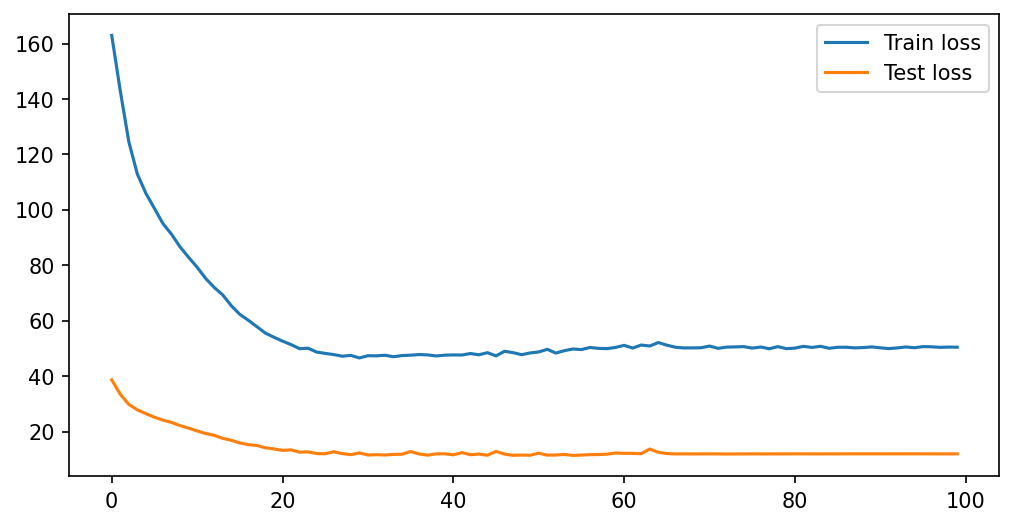

In [23]:
plt.figure(figsize=(8, 4), dpi=150)
plt.plot(range(epochs), train_loss_values, label="Train loss")
plt.plot(range(epochs), test_loss_values, label="Test loss")
plt.legend()

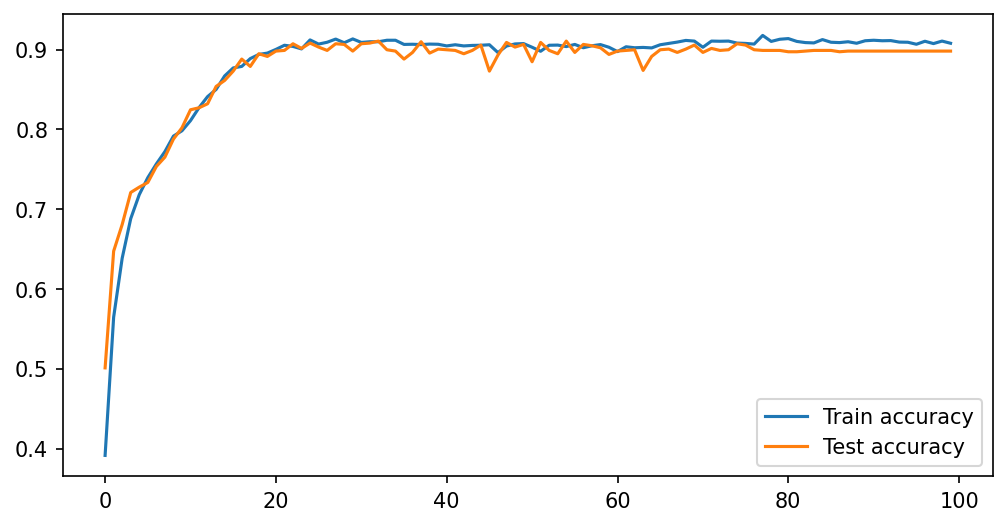

In [24]:
plt.figure(figsize=(8, 4), dpi=150)
plt.plot(range(epochs), train_metrics_values, label="Train accuracy")
plt.plot(range(epochs), test_metrics_values, label="Test accuracy")
plt.legend()

In [25]:
model.eval()
with torch.inference_mode():
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(test_dataloader, leave=True, total=len(test_dataloader))
    for i, batch_data in enumerate(pbar):
        _, batch_hyp, batch_label = forward_sequence_classification(
            model, batch_data[:-1], i2w=i2w, device="cuda"
        )
        list_hyp.extend(batch_hyp)
        list_label.extend(batch_label)

# Save prediction
results_df = pd.DataFrame({"sentiment": list_hyp, "label": list_label}).reset_index(
    drop=True
)
results_df.to_csv("pred.csv", index=False)

100%|██████████| 38/38 [00:01<00:00, 19.86it/s]


In [26]:
cm = torchmetrics.ConfusionMatrix(task='multiclass', num_classes=3)

In [27]:
y_pred = torch.tensor(
    list(
        map(lambda y: 0 if y == 'positive' else 1 if y == 'neutral' else 2 , list_hyp)
    )
)
ground_truth = torch.tensor(
    list(
        map(lambda y: 0 if y == 'positive' else 1 if y == 'neutral' else 2 , list_label)
    )
)

conf_mat = cm(y_pred, ground_truth)

<Axes: >

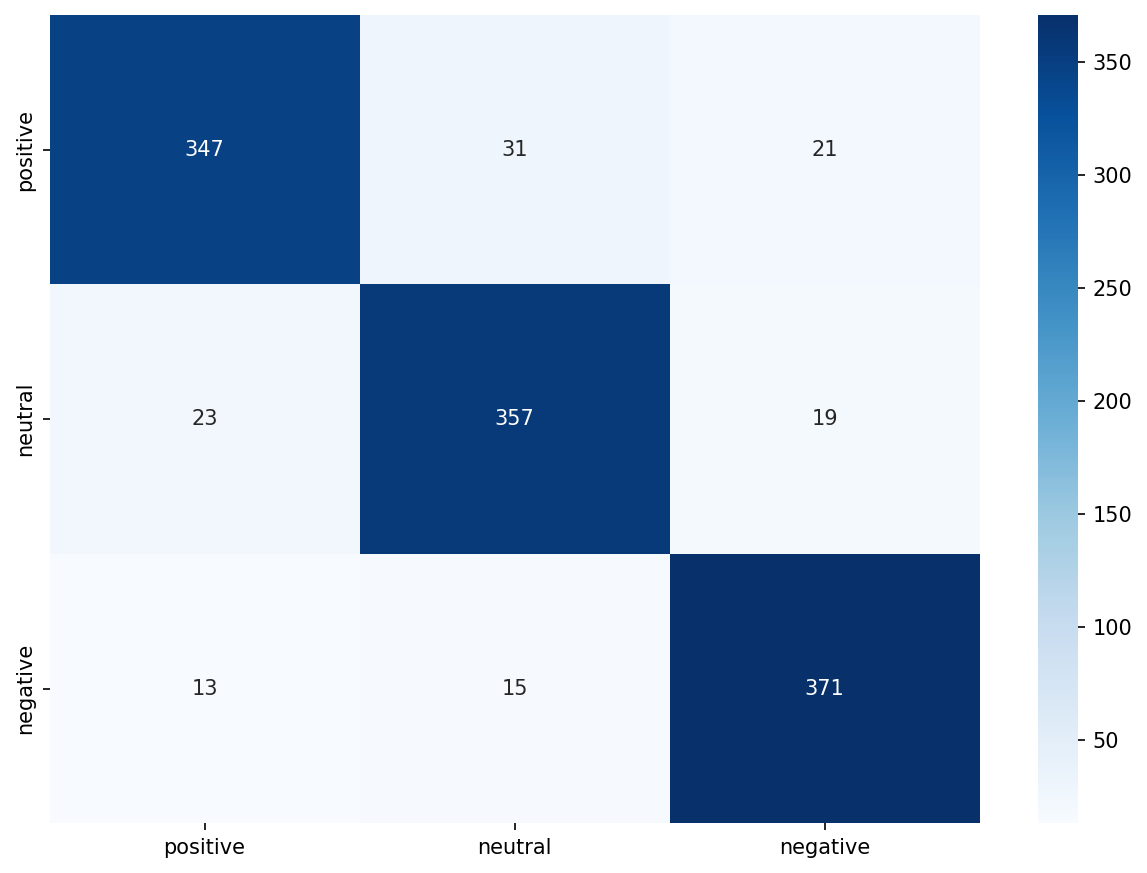

In [28]:
plt.figure(figsize=(10, 7), dpi=150)
sns.heatmap(
    conf_mat,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=w2i,
    yticklabels=w2i,
)

In [29]:
document_sentiment_metrics_fn(list_hyp, list_label)

{'ACC': 0.898078529657477,
 'F1': 0.8979305758736835,
 'REC': 0.8980785296574769,
 'PRE': 0.8981792334544485}